# 주제: 캐글 경진대회 참여해보기

## 1. 데이터 소개하기
- 링크: https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr  
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.  

### < Data fields >
ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 집의 가격(Target variable)  
bedrooms : 침실의 수  
bathrooms : 화장실의 수  
sqft_living : 주거 공간의 평방 피트(면적)   
sqft_lot : 부지의 평방 피트(면적)  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트(면적)  
sqft_basement : 지하실의 평방 피트(면적)  
yr_built : 지어진 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  

## 2. 진행 목표
Grid Search 기법을 활용해서 모델의 성능을 끌어올리고 최종 결과를 kaggle에 올리기

## 3. 시작

### (1) 라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join

import pandas as pd
import numpy as np
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### (2) 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### (3) 데이터 확인하기

In [3]:
print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### (4) 데이터 전처리하기

In [5]:
# price값만 따로 분리하기
y = train['price']
del train['price']

In [6]:
# train의 date 나누기
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

# train에서 id 열 제거
del train['id']

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
#test도 똑같이 date, id 수정
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [8]:
print(len(test.columns))
print(len(train.columns))

19
19


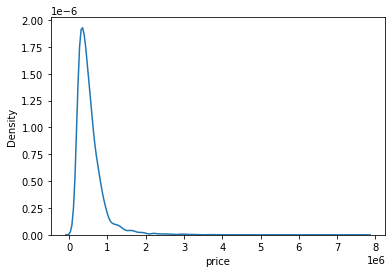

In [9]:
# 라벨 분포 시각화
sns.kdeplot(y)
plt.show()

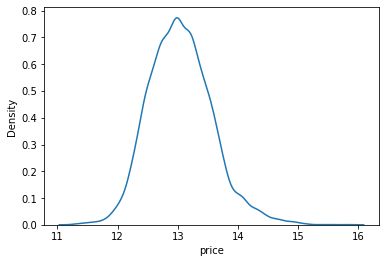

In [10]:
# 라벨값 로그 변환 후, 시각화 다시 하기
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

### (5) 여러가지 모델 적용하기
__첫 번째 시도__

In [11]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [12]:
random_state=2023

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [13]:
# get_scores(models, train, y) 함수로 만들기
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리 - 여기에도 random_state 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        #예측
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [14]:
get_scores(models, train, y)

,RMSE
RandomForestRegressor,140575.482483
GradientBoostingRegressor,127924.731417
XGBRegressor,123217.231718
LGBMRegressor,115213.997594


In [15]:
model = rdforest
def save_submission(model, train, y, test, model_name, rmsle=None):  
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [16]:
save_submission(model, train, y, test, 'RandomForestRegressor', rmsle=1)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_RandomForestRegressor_RMSLE_1.csv saved!


#### 첫 제출 결과:  
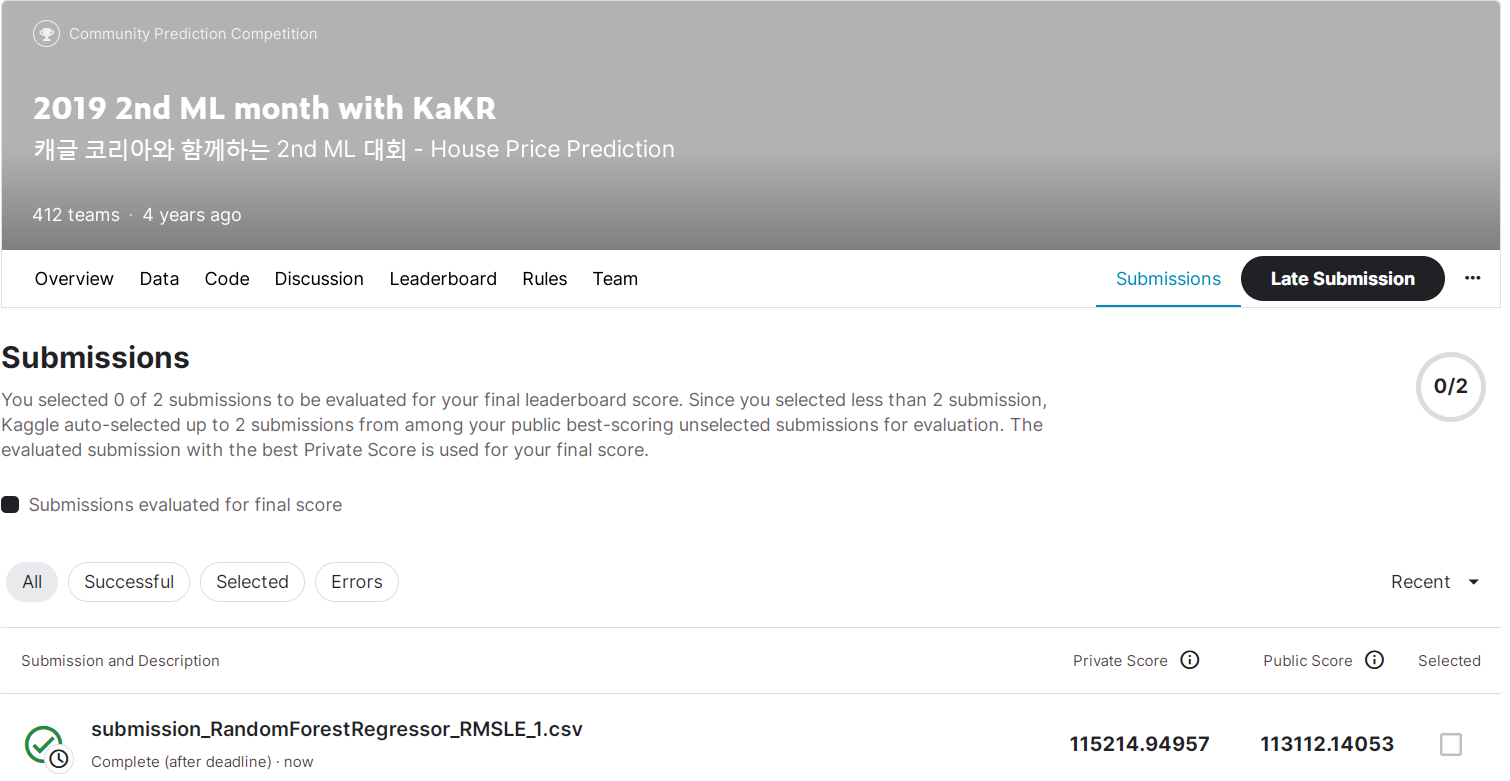

시도해볼 수 있는 방법  
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

### (6) 파라미터 튜닝하기

__두 번째 시도__

In [19]:
from sklearn.model_selection import GridSearchCV

#파라미터 넣기
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

#파라미터 튜닝하고 결과값 데이터프레임으로 만드는 함수
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                              scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, np.expm1(y))

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSE')

    return results

In [20]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSE
3,10,100,-1.636539e+10,127927.284712
2,10,50,-1.724703e+10,131327.941095
1,1,100,-3.856707e+10,196385.016448
0,1,50,-4.790311e+10,218867.798643


-> 가장 좋은 조합은 max_depth=10, n_estimators=100이다. 이 값을 넣어서 제출할 것이다.

In [21]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [22]:
# submisssion 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [23]:
#결과값에 붙여넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [24]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '2')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_2.csv
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.0s
[CV] END .....................max_depth=1

#### 두 번째 제출 결과: 
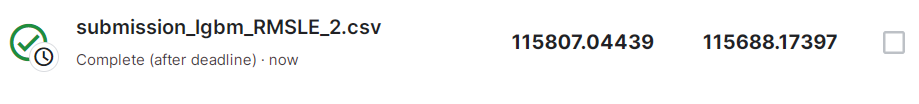

첫 번째 제출보다 값이 더 큰 것을 보아 좀더 파라미터 수정이 필요할 것으로 보인다. 

__세 번째 시도__

In [36]:
#파라미터 넣기
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [10, 12],
    'learning_rate' : [0.1, 0.05], 
    'boosting_type' : ['gbdt', 'dart', 'goss']
}

In [37]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSE
17,goss,0.10,10,200,-1.545756e+10,124328.443866
23,goss,0.05,12,200,-1.554445e+10,124677.378735
16,goss,0.10,10,150,-1.568647e+10,125245.656131
21,goss,0.05,10,200,-1.570605e+10,125323.793547
19,goss,0.10,12,200,-1.576753e+10,125568.835536
18,goss,0.10,12,150,-1.581651e+10,125763.706777
22,goss,0.05,12,150,-1.597187e+10,126379.871704
20,goss,0.05,10,150,-1.616982e+10,127160.614930
7,gbdt,0.05,12,200,-1.619880e+10,127274.489929
0,gbdt,0.10,10,150,-1.623069e+10,127399.735372


In [38]:
model = LGBMRegressor(max_depth=10, n_estimators=200, learning_rate = 0.1, boosting_type = 'goss', random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 469611.90670565,  504207.88501109, 1331598.68570268, ...,
        478024.80698878,  305119.75484781,  452683.85765219])

In [39]:
# submisssion 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
#결과값에 붙여넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.696119e+05
1,15036,5.042079e+05
2,15037,1.331599e+06
3,15038,3.030353e+05
4,15039,3.433539e+05


In [40]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '3')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_3.csv
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   3.5s
[CV] END .....................max_depth=12, n_estimators=100; total time=   2.1s
[CV] END .....................max_depth=12, n_estimators=150; total time=   3.0s
[CV] END .....................max_depth=12, n_estimators=200; total time=   3.4s
[CV] END .....................max_depth=15, n_estimators=100; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=150; total time=   2.2s
[CV] END .....................max_depth=15, n_estimators=200; total time=   2.6s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=150; total time=   2.8s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=200; total time=   2.9s
[CV] END .learning_rate=0.01, max_depth=12, n_estimators=150; total time=   2.8s
[CV] END .learning_rate=0.01, max_depth=1

[CV] END .....................max_depth=10, n_estimators=100; total time=   2.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=   2.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=   3.8s
[CV] END .....................max_depth=12, n_estimators=150; total time=   3.2s
[CV] END .....................max_depth=12, n_estimators=200; total time=   2.9s
[CV] END .....................max_depth=15, n_estimators=150; total time=   2.0s
[CV] END .....................max_depth=15, n_estimators=200; total time=   3.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=150; total time=   3.0s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=200; total time=   2.9s
[CV] END .learning_rate=0.01, max_depth=12, n_estimators=150; total time=   2.6s
[CV] END .learning_rate=0.01, max_depth=12, n_estimators=200; total time=   4.0s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=150; total time=   3.1s
[CV] END .learning_rate=0.05

#### 세 번째 결과 제출: 
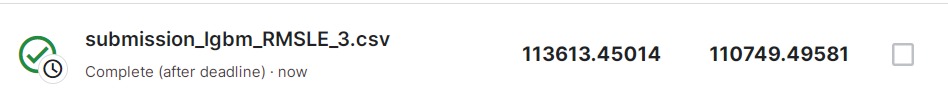
-> 110000에 점점 가까워지고 있다. 이번엔 좀 더 세부적인 조정을 해야겠다.

In [42]:
#파라미터 넣기
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [10, 11, 12],
    'learning_rate' : [0.1, 0.05], 
    'boosting_type' : ['goss']
}

In [43]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSE
17,goss,0.05,12,250,-1.533293e+10,123826.213504
2,goss,0.10,10,250,-1.539948e+10,124094.658967
14,goss,0.05,11,250,-1.544104e+10,124261.983580
11,goss,0.05,10,250,-1.545246e+10,124307.927733
1,goss,0.10,10,200,-1.545756e+10,124328.443866
16,goss,0.05,12,200,-1.554445e+10,124677.378735
5,goss,0.10,11,250,-1.554825e+10,124692.641696
4,goss,0.10,11,200,-1.559570e+10,124882.758894
8,goss,0.10,12,250,-1.567222e+10,125188.755930
0,goss,0.10,10,150,-1.568647e+10,125245.656131


In [44]:
model = LGBMRegressor(max_depth=12, n_estimators=250, learning_rate = 0.05, boosting_type = 'goss', random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 502517.93552176,  449614.24676207, 1434991.74026022, ...,
        473057.92554575,  318034.87565203,  419978.41267263])

In [45]:
# submisssion 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
#결과값에 붙여넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.025179e+05
1,15036,4.496142e+05
2,15037,1.434992e+06
3,15038,3.013203e+05
4,15039,3.316499e+05


In [46]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '4')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_4.csv
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=150; total time=   3.4s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=200; total time=   4.6s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=250; total time=   5.7s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=150; total time=   3.4s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=200; total time=   3.2s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=250; total time=   4.4s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=150; total time=   3.8s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=200; total time=   3.7s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=250; total time=   5.8s
[CV] END boosting_type=goss, learning_rat

#### 네 번째 결과 제출:
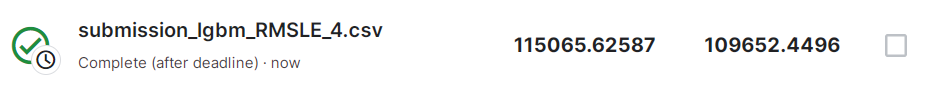
-> public score는 110000점보다 낮게 나왔지만 private score는 오히려 점수가 높아졌다. 

In [49]:
#파라미터 넣기
param_grid = {
    'n_estimators': [300, 350, 400],
    'max_depth': [11, 12, 13],
    'learning_rate' : [0.1, 0.05], 
    'boosting_type' : ['goss']
}

In [50]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSE
17,goss,0.05,13,400,-1.497086e+10,122355.467116
14,goss,0.05,12,400,-1.497397e+10,122368.159963
16,goss,0.05,13,350,-1.502999e+10,122596.876861
13,goss,0.05,12,350,-1.504200e+10,122645.851032
11,goss,0.05,11,400,-1.508976e+10,122840.397700
15,goss,0.05,13,300,-1.510635e+10,122907.905993
12,goss,0.05,12,300,-1.513332e+10,123017.551531
10,goss,0.05,11,350,-1.519044e+10,123249.484736
9,goss,0.05,11,300,-1.527302e+10,123584.046692
7,goss,0.10,13,350,-1.544195e+10,124265.633917


In [51]:
model = LGBMRegressor(max_depth=13, n_estimators=400, learning_rate = 0.05, boosting_type = 'goss', random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 481501.10463605,  494251.16884053, 1363081.08355121, ...,
        480026.64965674,  301267.58641845,  423771.58794766])

In [52]:
# submisssion 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
#결과값에 붙여넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.815011e+05
1,15036,4.942512e+05
2,15037,1.363081e+06
3,15038,3.129727e+05
4,15039,3.251957e+05


In [53]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '5')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_5.csv


#### 다섯 번째 결과 제출: 
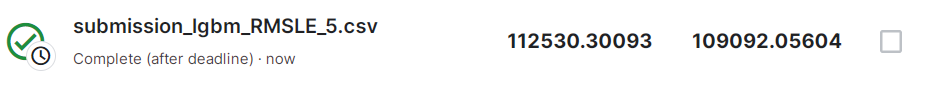
-> 다행히 가장 낮은 점수를 보이고 있다. 조금만 더 파라미터를 수정하면 될 것 같다.

__여섯 번째 시도__

In [56]:
#파라미터 넣기
param_grid = {
    'n_estimators': [400, 450, 500],
    'max_depth': [13, 14, 15],
    'learning_rate' : [0.03, 0.05], 
    'boosting_type' : ['goss']
}

In [57]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSE
17,goss,0.05,15,500,-1.472922e+10,121364.008496
16,goss,0.05,15,450,-1.474743e+10,121438.980529
14,goss,0.05,14,500,-1.483813e+10,121811.861572
15,goss,0.05,15,400,-1.484135e+10,121825.077482
13,goss,0.05,14,450,-1.488128e+10,121988.834811
11,goss,0.05,13,500,-1.491385e+10,122122.291930
12,goss,0.05,14,400,-1.492558e+10,122170.303039
10,goss,0.05,13,450,-1.496064e+10,122313.681387
9,goss,0.05,13,400,-1.497086e+10,122355.467116
2,goss,0.03,13,500,-1.506066e+10,122721.880326


In [58]:
model = LGBMRegressor(max_depth=15, n_estimators=500, learning_rate = 0.05, boosting_type = 'goss', random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 503391.92902234,  475613.99691838, 1357638.50500026, ...,
        486345.65430064,  310523.19886847,  434207.36965437])

In [59]:
# submisssion 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
#결과값에 붙여넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.033919e+05
1,15036,4.756140e+05
2,15037,1.357639e+06
3,15038,2.897595e+05
4,15039,3.255607e+05


In [60]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '6')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_6.csv


#### 여섯 번째 결과 제출: 
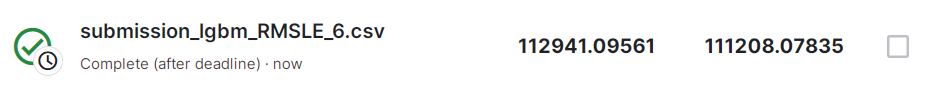
-> 다시 점수가 높아진 것을 보아 과적합된 것을 알 수 있다. 그러므로 n_estimatiors는 여기까지만 올리고 다른 파라미터를 조절해야할 것 같다.

__일곱 번째 시도__

In [61]:
#파라미터 넣기
param_grid = {
    'n_estimators': [400, 450, 500],
    'max_depth': [15, 20, 25],
    'learning_rate' : [0.06, 0.05], 
    'boosting_type' : ['goss']
}

In [62]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=250; total time=   5.5s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=300; total time=   5.8s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=350; total time=   7.8s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=250; total time=   5.8s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=300; total time=   6.3s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=350; total time=   6.2s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=300; total time=   5.0s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=350; total time=   5.8s
[CV] END boosting_type=goss, learning_rate=0.05, max_depth=10, n_estimators=250; total time=   3.8s
[CV] END boosting_type=goss, learning_rate=0.05

[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=250; total time=   5.6s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=300; total time=   5.6s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=350; total time=   5.7s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=250; total time=   3.9s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=300; total time=   4.6s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=350; total time=   7.6s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=250; total time=   3.9s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=250; total time=   4.4s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=300; total time=   5.6s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=350; total time=   7.6s
[CV] END b

[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=250; total time=   4.0s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=300; total time=   5.6s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=10, n_estimators=350; total time=   5.7s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=250; total time=   5.9s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=300; total time=   6.8s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=11, n_estimators=350; total time=   6.1s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=250; total time=   5.4s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=300; total time=   6.2s
[CV] END boosting_type=goss, learning_rate=0.1, max_depth=12, n_estimators=350; total time=   7.7s
[CV] END boosting_type=goss, learning_rate=0.05, max_depth=10, n_estimators=250; total time=   4.8s
[CV] END 

,boosting_type,learning_rate,max_depth,n_estimators,score,RMSE
11,goss,0.05,15,500,-1.472922e+10,121364.008496
10,goss,0.05,15,450,-1.474743e+10,121438.980529
17,goss,0.05,25,500,-1.480808e+10,121688.440719
14,goss,0.05,20,500,-1.480808e+10,121688.440719
5,goss,0.06,20,500,-1.481766e+10,121727.830704
8,goss,0.06,25,500,-1.481766e+10,121727.830704
7,goss,0.06,25,450,-1.482975e+10,121777.460843
4,goss,0.06,20,450,-1.482975e+10,121777.460843
9,goss,0.05,15,400,-1.484135e+10,121825.077482
16,goss,0.05,25,450,-1.484373e+10,121834.862929


In [73]:
model = LGBMRegressor(max_depth=25, n_estimators=450, learning_rate = 0.05, boosting_type = 'goss', random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 512314.18806021,  454276.37286303, 1408028.24398411, ...,
        483971.04724877,  306302.29336186,  416044.19422258])

In [74]:
# submisssion 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
#결과값에 붙여넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.123142e+05
1,15036,4.542764e+05
2,15037,1.408028e+06
3,15038,2.913354e+05
4,15039,3.248471e+05


In [75]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '10')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_10.csv


#### 열 번째 결과: 
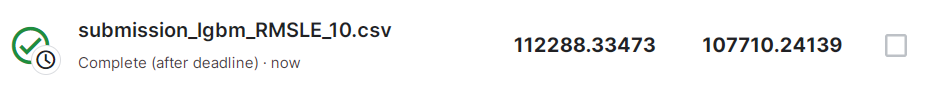
-> 10번째만에 가장 최저점을 다시 찍을 수 있었다. 하지만 10번의 튜닝동안에도 점수가 120000점 아래로 떨어지지 않을 것 같아서 다른 방법을 사용하기로 하였다.  

바로 앙상블기법을 이용하는 것이다.
는 얼어죽을...대실패햇다

In [80]:
from sklearn.ensemble import VotingRegressor

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state, max_depth=25, n_estimators=450, learning_rate = 0.05, boosting_type = 'goss')
rdforest = RandomForestRegressor(random_state=random_state)

# 보팅 앙상블을 구성
ensemble = VotingRegressor(estimators=[('BG', gboost), ('XGB', xgboost), ('LGBM', lightgbm), ('RF', rdforest)],  n_jobs=-1)

# 앙상블 모델을 학습
ensemble.fit(train, y)

# 앙상블 모델로 예측
prediction = ensemble.predict(test)
prediction = np.expm1(prediction)

In [81]:
# submisssion 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
#결과값에 붙여넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.989572e+05
1,15036,4.526627e+05
2,15037,1.301801e+06
3,15038,3.000791e+05
4,15039,3.193819e+05


In [82]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '12')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_12.csv
